In [87]:
## 모듈 로드
import pandas as pd
from konlpy.tag import Okt
from collections import Counter
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch import nn


import os
import json
import re
import string

In [88]:
class reviewClassifierModel(nn.Module):
    def __init__(self, n_vocab, hidden_dim, embedding_dim, n_classes,
                 n_layers, dropout=0.5, bidirectional=True) -> None:
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,         # num_embeddings = vocab이 들어감
            embedding_dim=embedding_dim,
            padding_idx=0
        )
        self.model = nn.LSTM(
            input_size = embedding_dim,         # Input의 사이즈에 해당하는 수
            hidden_size=hidden_dim,             # 은닉층의 사이즈에 해당하는 수
            num_layers=n_layers,                # RNN의 은닉층 레이어 개수, default = 1
            bidirectional=bidirectional,        # bidrectional True일시 양방향 RNN, default = False
            dropout=dropout,                    # dropout 비율설정 기본값 0
            batch_first=True,                   # True일 경우 Output 사이즈는 (batch, seq, feature) 기본값 False
        )
        if bidirectional:
            self.classifier1 = nn.Linear(hidden_dim*2,n_classes)
            self.classifier2 = nn.Linear(hidden_dim*2,1)
        else:
            self.classifier1 = nn.Linear(hidden_dim,n_classes)
            self.classifier2 = nn.Linear(hidden_dim,1)
        self.dropout = nn.Dropout(dropout)

    def forward(self,inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings)
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)
        classesd = self.classifier1(last_output)
        logits = self.classifier2(last_output)

        # LogSoftmax 적용
        classesd = nn.LogSoftmax(dim=1)(classesd)  # 다중 클래스 출력에 LogSoftmax 적용

        return classesd, logits

In [89]:
# 데이터 로드함수
def load_data(csvfile1,csvfile2):                           # csv 파일 읽기
    trainDF = pd.read_csv(csvfile1, usecols=[1, 2, 4])      # 필요한 컬럼 추출

    testDF = pd.read_csv(csvfile2, usecols=[1, 2, 4])
    return trainDF, testDF                                  # 리턴


In [90]:
# 데이터 인코딩 함수
def data_encoding(DF):
    labelCD = DF.Aspect.unique().tolist()                               # Aspect 컬럼의 유니크 값 리스트 
    DF['Aspect'] = DF['Aspect'].map(lambda x: labelCD.index(x))         # 다중 분류 라벨링 인코딩
    DF.loc[DF['SentimentPolarity'] == -1, 'SentimentPolarity'] = 0      # 2진 분류 인코딩
    return DF, labelCD


In [91]:
# 단어사전 만드는 함수
def build_vocab(corpus, n_vocab, special_tokens):
    counter = Counter()                                     # Counter 인스턴스 생성
    for tokens in corpus:                                   # 입력받은 corpus로 카운터 모델 초기화
        counter.update(tokens)
    vocab = special_tokens.copy()                           
    for token, count in counter.most_common(n_vocab):       # 상위 중복 언어 단어사전에 추가
        vocab.append(token)
    return vocab


In [92]:
# 패딩함수
def pad_sequences(sequences, max_length, pad_value):
    result = list()
    for sequence in sequences:                              
        sequence = sequence[:max_length]                    # max_length 만큼 자르기
        pad_length = max_length - len(sequence)             # max_length보다 단어가 적다면
        padded_sequence = sequence + [pad_value] * pad_length   # 정해진 수 채우기
        result.append(padded_sequence)
    return np.asarray(result)


In [93]:
# 자연어 인코딩 함수
def encoding_ids(token_to_id, tokens, unk_id):
    return [
        [token_to_id.get(token, unk_id) for token in review] for review in tokens
    ]   # 자연어 인코딩


In [94]:
# # 학습함수
# def model_train(model, datasets, cl_criterion, bn_criterion, optimizer, device, interval):
#     model.train()
#     losses = []

#     for step, (input_ids, labels) in enumerate(datasets):
#         input_ids = input_ids.to(device)                    # 인풋데이터
#         cl_labels = labels[:, 0].to(device)                 # 라벨 다중분류
#         bn_labels = labels[:, 1].to(device).float()         # 라벨 2진분류  (float형)

#         # Forward pass
#         classesd, logits = model(input_ids)

#         # Calculate losses
#         loss_cl = cl_criterion(classesd, cl_labels)         # 
#         loss_bn = bn_criterion(logits.squeeze(), bn_labels) # 
#         loss = loss_cl + loss_bn
#         losses.append(loss.item())

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if step % interval == 0:
#             print(f'Train Loss {step} : {np.mean(losses)}')

#     return losses

In [95]:
def model_train(model, datasets, cl_criterion, bn_criterion, optimizer, device, interval):
    model.train()
    losses = []

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)                    # 인풋데이터
        cl_labels = labels[:, 0].to(device)                 # 라벨 다중분류
        bn_labels = labels[:, 1].to(device).float()         # 라벨 2진분류  (float형)

        # Forward pass
        classesd, logits = model(input_ids)

        # Calculate losses
        loss_cl = cl_criterion(classesd, cl_labels)         # 
        loss_bn = bn_criterion(logits.squeeze(), bn_labels) # 
        loss = loss_cl + loss_bn
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % interval == 0:
            print(f'Train Loss {step} : {np.mean(losses)}')

    return losses


In [96]:
from sklearn.metrics import f1_score

def model_test(model, datasets, cl_criterion, bn_criterion, device, epoch):
    model.eval()
    losses = []
    cl_score = []
    bn_score = []
    
    all_cl_predictions = []
    all_cl_labels = []

    with torch.no_grad(): 
        for step, (input_ids, labels) in enumerate(datasets):
            input_ids = input_ids.to(device)
            cl_labels = labels[:, 0].to(device).long()  # 다중 클래스 레이블
            bn_labels = labels[:, 1].to(device).float()  # 이진 분류 레이블

            classesd, logits = model(input_ids)

            loss_cl = cl_criterion(classesd, cl_labels)
            loss_bn = bn_criterion(logits.squeeze(), bn_labels)
            loss = loss_cl + loss_bn
            losses.append(loss.item())
            
            cl_predictions = torch.argmax(torch.softmax(classesd, dim=1), dim=1)  # 다중 클래스 예측
            cl_score.extend(cl_predictions.eq(cl_labels).cpu().numpy())  # 정확도 계산
            
            bn_predictions = (torch.sigmoid(logits) > 0.5).int().squeeze()  # 이진 예측
            bn_score.extend(bn_predictions.eq(bn_labels.int()).cpu().numpy())  # 정확도 계산
            
            #F1-score 계산
            all_cl_predictions.extend(cl_predictions.cpu().numpy())
            all_cl_labels.extend(cl_labels.cpu().numpy())

        # F1-스코어 계산
        f1 = f1_score(all_cl_labels, all_cl_predictions, average='micro')
        
        # 정확도 계산
        cl_accuracy = np.mean(cl_score)
        bn_accuracy = np.mean(bn_score)
        
        print(f'Epoch {epoch} - Val Loss: {np.mean(losses)}, bn_score Val Accuracy: {bn_accuracy}, cl_score Val Accuracy: {cl_accuracy}, F1 Score: {f1}')
    
    return cl_accuracy, bn_accuracy, f1,cl_score,bn_score


In [97]:
N_VOCAB = 5000
MAX_LENGTH =25
EPOCHS =100
INTERVAL = 500
BATCH_SIZE = 64
LR = 0.001
special_tokens = ['<pad>', '<unk>']

raw_trainDF, raw_testDF = load_data('./DATA/Train_Fashion_reivew.csv','./DATA/Val_Fashion_reivew.csv')

In [98]:
raw_trainDF

,Aspect,SentimentText,SentimentPolarity
0,착용감,넘 편해서,1
1,소재,니트재질이라보니 보풀감은 어쩔수업머요ㅠㅠ,1
2,활용성,자주 손가입었어요,1
3,디자인,레깅스에 가깝게보여 좋았는데,1
4,디자인,받고보니 디잔이다릅니다,-1
...,...,...,...
1228,디자인,예쁜 가방도 마련했겠다,1
1229,품질,일단 바퀴의 성능이 탁월해서 너무 좋네요...,1
1230,소재,외관에 스크래치도 덜 가구요..,1
1231,색상,색상도 좋으네요,1


In [99]:
raw_trainDF['Aspect'].value_counts()

Aspect
디자인            131
사이즈            118
가격             107
품질             101
소재              93
기능              90
착화감             83
착용감             69
색상              60
치수/사이즈          51
무게              45
길이              44
두께              37
핏               35
신축성             32
활용성             22
촉감              21
사용성             15
사이즈/폭/길이/두께     14
사용성/편의성         14
기능성             11
마감              10
내구성              8
제품구성             8
냄새               8
굽                5
수납               1
Name: count, dtype: int64

In [100]:
raw_trainDF.loc[raw_trainDF['Aspect'] == '길이', 'Aspect'] = '사이즈'
raw_trainDF.loc[raw_trainDF['Aspect'] == '핏', 'Aspect'] = '사이즈'
raw_trainDF.loc[raw_trainDF['Aspect'] == '무게', 'Aspect'] = '착용감'
raw_trainDF.loc[raw_trainDF['Aspect'] == '신축성', 'Aspect'] = '착용감'
raw_trainDF.loc[raw_trainDF['Aspect'] == '마감', 'Aspect'] = '품질'
raw_trainDF.loc[raw_trainDF['Aspect'] == '치수/사이즈', 'Aspect'] = '사이즈'
raw_trainDF.loc[raw_trainDF['Aspect'] == '사용성', 'Aspect'] = '활용성'
raw_trainDF.loc[raw_trainDF['Aspect'] == '사이즈/폭/길이/두께', 'Aspect'] = '사이즈'
raw_trainDF.loc[raw_trainDF['Aspect'] == '사용성/편의성', 'Aspect'] = '활용성'

In [101]:
raw_trainDF

,Aspect,SentimentText,SentimentPolarity
0,착용감,넘 편해서,1
1,소재,니트재질이라보니 보풀감은 어쩔수업머요ㅠㅠ,1
2,활용성,자주 손가입었어요,1
3,디자인,레깅스에 가깝게보여 좋았는데,1
4,디자인,받고보니 디잔이다릅니다,-1
...,...,...,...
1228,디자인,예쁜 가방도 마련했겠다,1
1229,품질,일단 바퀴의 성능이 탁월해서 너무 좋네요...,1
1230,소재,외관에 스크래치도 덜 가구요..,1
1231,색상,색상도 좋으네요,1


In [102]:
raw_trainDF['Aspect'].value_counts()

Aspect
사이즈     262
착용감     146
디자인     131
품질      111
가격      107
소재       93
기능       90
착화감      83
색상       60
활용성      51
두께       37
촉감       21
기능성      11
냄새        8
제품구성      8
내구성       8
굽         5
수납        1
Name: count, dtype: int64

In [103]:
raw_testDF

,Aspect,SentimentText,SentimentPolarity
0,기능,배도 편하게 눌러주고,1
1,길이,미디가 길어 편하다고..,1
2,색상,다섯가지 색상 모두 이쁘네요^^,1
3,기능,입자마자 시원하고,1
4,기능,배 부분도 잘 잡아주고,1
...,...,...,...
15755,품질,품질 좋아요,1
15756,품질,우선 박음질이 허접합니다.,-1
15757,색상,색상은 이뻐요,1
15758,품질,검정백은 지퍼가 뻑뻑해서 잘 안닫혀요,-1


In [104]:
raw_testDF['Aspect'].value_counts()

Aspect
사이즈            1828
디자인            1421
가격             1282
품질             1213
착용감            1211
기능             1197
소재              966
착화감             867
핏               845
색상              840
신축성             728
치수/사이즈          525
길이              494
무게              484
두께              418
활용성             223
제품구성            200
촉감              186
사용성/편의성         160
사용성             159
기능성             139
사이즈/폭/길이/두께     125
마감               93
내구성              61
수납               40
굽                28
냄새               27
Name: count, dtype: int64

In [105]:
raw_testDF.loc[raw_testDF['Aspect'] == '길이', 'Aspect'] = '사이즈'
raw_testDF.loc[raw_testDF['Aspect'] == '핏', 'Aspect'] = '사이즈'
raw_testDF.loc[raw_testDF['Aspect'] == '무게', 'Aspect'] = '착용감'
raw_testDF.loc[raw_testDF['Aspect'] == '신축성', 'Aspect'] = '착용감'
raw_testDF.loc[raw_testDF['Aspect'] == '마감', 'Aspect'] = '품질'
raw_testDF.loc[raw_testDF['Aspect'] == '치수/사이즈', 'Aspect'] = '사이즈'
raw_testDF.loc[raw_testDF['Aspect'] == '사용성', 'Aspect'] = '활용성'
raw_testDF.loc[raw_testDF['Aspect'] == '사이즈/폭/길이/두께', 'Aspect'] = '사이즈'
raw_testDF.loc[raw_testDF['Aspect'] == '사용성/편의성', 'Aspect'] = '활용성'

In [106]:
raw_testDF['Aspect'].value_counts()

Aspect
사이즈     3817
착용감     2423
디자인     1421
품질      1306
가격      1282
기능      1197
소재       966
착화감      867
색상       840
활용성      542
두께       418
제품구성     200
촉감       186
기능성      139
내구성       61
수납        40
굽         28
냄새        27
Name: count, dtype: int64

In [107]:
top10_train=raw_trainDF['Aspect'].value_counts().nlargest(n=10).index.tolist()
trainDF=raw_trainDF.drop(index=raw_trainDF[~raw_trainDF['Aspect'].isin(values=top10_train)].index).reset_index()

top10_test=raw_testDF['Aspect'].value_counts().nlargest(n=10).index.tolist()
testDF=raw_testDF.drop(index=raw_testDF[~raw_testDF['Aspect'].isin(values=top10_test)].index).reset_index()

In [108]:
trainDF

,index,Aspect,SentimentText,SentimentPolarity
0,0,착용감,넘 편해서,1
1,1,소재,니트재질이라보니 보풀감은 어쩔수업머요ㅠㅠ,1
2,2,활용성,자주 손가입었어요,1
3,3,디자인,레깅스에 가깝게보여 좋았는데,1
4,4,디자인,받고보니 디잔이다릅니다,-1
...,...,...,...,...
1129,1228,디자인,예쁜 가방도 마련했겠다,1
1130,1229,품질,일단 바퀴의 성능이 탁월해서 너무 좋네요...,1
1131,1230,소재,외관에 스크래치도 덜 가구요..,1
1132,1231,색상,색상도 좋으네요,1


In [109]:
trainDF, aspectCD = data_encoding(trainDF)
testDF, _ = data_encoding(testDF)

In [110]:
trainDF

,index,Aspect,SentimentText,SentimentPolarity
0,0,0,넘 편해서,1
1,1,1,니트재질이라보니 보풀감은 어쩔수업머요ㅠㅠ,1
2,2,2,자주 손가입었어요,1
3,3,3,레깅스에 가깝게보여 좋았는데,1
4,4,3,받고보니 디잔이다릅니다,0
...,...,...,...,...
1129,1228,3,예쁜 가방도 마련했겠다,1
1130,1229,8,일단 바퀴의 성능이 탁월해서 너무 좋네요...,1
1131,1230,1,외관에 스크래치도 덜 가구요..,1
1132,1231,7,색상도 좋으네요,1


In [111]:
aspectCD

['착용감', '소재', '활용성', '디자인', '가격', '사이즈', '기능', '색상', '품질', '착화감']

In [119]:
# 토큰화 및 불용어 처리 ------------------------------------------------------------------------------------------------------------
punc=string.punctuation

for p in punc:
    trainDF['SentimentText'] = trainDF['SentimentText'].str.replace(p, '')
    testDF['SentimentText']=testDF['SentimentText'].str.replace(p,'')

m=re.compile('[^ ㄱ-ㅣ가-힣]+')

trainDF['SentimentText']=trainDF['SentimentText'].apply(lambda x: m.sub(' ', x))
testDF['SentimentText']=testDF['SentimentText'].apply(lambda x: m.sub(' ', x))

stop_word='./stopwords.txt'

with open(stop_word, 'r', encoding='utf-8') as f:
    stop_words = [line.strip() for line in f]


tokenizer = Okt()
train_tokens = [[token for token in tokenizer.morphs(text) if token not in stop_words] for text in trainDF['SentimentText']]
test_tokens = [[token for token in tokenizer.morphs(text) if token not in stop_words] for text in testDF['SentimentText']]
# -------------------------------------------------------------------------------------------------------------------------------


vocab = build_vocab(train_tokens, N_VOCAB, special_tokens)
token_to_id = {token: idx for idx, token in enumerate(vocab)}
id_to_token = {idx: token for idx, token in enumerate(vocab)}

pad_id = token_to_id['<pad>']
unk_id = token_to_id['<unk>']
train_ids = encoding_ids(token_to_id, train_tokens, unk_id)
test_ids = encoding_ids(token_to_id, test_tokens, unk_id)
train_ids = pad_sequences(train_ids, MAX_LENGTH, pad_id)
test_ids = pad_sequences(test_ids, MAX_LENGTH, pad_id)

# 텐서화
train_ids = torch.tensor(train_ids, dtype=torch.long)
test_ids = torch.tensor(test_ids, dtype=torch.long)

# 레이블 텐서화
train_labels = torch.tensor(list(zip(trainDF['Aspect'].values, trainDF['SentimentPolarity'].values)), dtype=torch.long)
test_labels = torch.tensor(list(zip(testDF['Aspect'].values, testDF['SentimentPolarity'].values)), dtype=torch.float32)

# 데이터셋 생성
train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

# 모델 초기화
n_vocab = len(token_to_id)  # 어휘 크기 계산
hidden_dim = 64 
embedding_dim = 128
n_layers = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier = reviewClassifierModel(
    n_vocab=n_vocab, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_classes=len(aspectCD), n_layers=n_layers
).to(device)

# 손실 함수 및 최적화기 설정
cl_criterion = nn.NLLLoss().to(device)
bn_criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.AdamW(classifier.parameters(), lr=LR, weight_decay=0.01)


# 결과를 저장할 DataFrame 생성
results_df = pd.DataFrame(columns=['Val Loss', 'bn_score Val Accuracy', 'cl_score Val Accuracy'])

for epoch in range(EPOCHS):
    model_train(classifier, train_loader, cl_criterion, bn_criterion, optimizer, device, INTERVAL)
    model_test(classifier, test_loader, cl_criterion, bn_criterion, device, epoch)

    train_losses = model_train(classifier, train_loader, cl_criterion, bn_criterion, optimizer, device, INTERVAL)
    test_losses= model_test(classifier, train_loader, cl_criterion, bn_criterion, device, epoch)
    bi_score = model_test(classifier, train_loader, cl_criterion, bn_criterion, device, epoch)  
    multi_score= model_test(classifier, train_loader, cl_criterion, bn_criterion, device, epoch)  
    f1score = model_test(classifier, train_loader, cl_criterion, bn_criterion, device, epoch)  
  

    # 모델 저장 (에포크 번호 추가)
    model_save_path = f'./saved_model/review_classifier_epoch_{epoch + 1}.pt'  # 에포크 번호 포함
    torch.save(classifier.state_dict(), model_save_path)
    print(f'Model saved at {model_save_path}')

print("평가 결과가 저장되었습니다.")



Train Loss 0 : 2.9934961795806885
Epoch 0 - Val Loss: 2.9446851305339647, bn_score Val Accuracy: 0.6436805129254485, cl_score Val Accuracy: 0.08744287565650365, F1 Score: 0.08744287565650365
Train Loss 0 : 2.8757834434509277
Epoch 0 - Val Loss: 2.836358626683553, bn_score Val Accuracy: 0.6622574955908289, cl_score Val Accuracy: 0.2310405643738977, F1 Score: 0.2310405643738977
Epoch 0 - Val Loss: 2.837020476659139, bn_score Val Accuracy: 0.6622574955908289, cl_score Val Accuracy: 0.2310405643738977, F1 Score: 0.2310405643738977
Epoch 0 - Val Loss: 2.8362657096650867, bn_score Val Accuracy: 0.6622574955908289, cl_score Val Accuracy: 0.2310405643738977, F1 Score: 0.2310405643738977
Epoch 0 - Val Loss: 2.8377607266108194, bn_score Val Accuracy: 0.6622574955908289, cl_score Val Accuracy: 0.2310405643738977, F1 Score: 0.2310405643738977
Model saved at ./saved_model/review_classifier_epoch_1.pt
Train Loss 0 : 2.8618006706237793
Epoch 1 - Val Loss: 3.0100144552147907, bn_score Val Accuracy: 0.

In [120]:
import pickle

# 단어 사전 저장
with open('vocab.pkl', 'wb') as f:
    pickle.dump(token_to_id, f)

print("단어 사전이 저장되었습니다.")

단어 사전이 저장되었습니다.


NameError: name 'test_losses_flat' is not defined

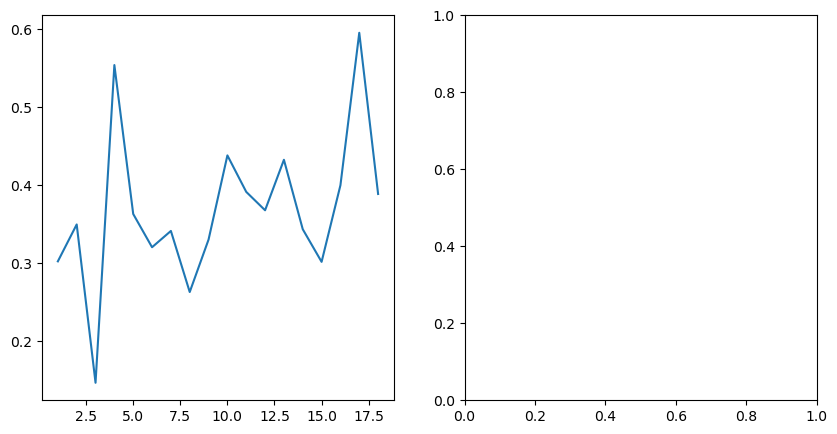

In [125]:
import matplotlib.pyplot as plt

# Assuming model_test.losses, model_test.bn_score, etc. are already defined
fg, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plotting the training and test losses
axes[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train')
axes[0].plot(range(1, len(test_losses_flat) + 1), test_losses_flat, label='Test')
axes[0].set_title('LOSS')
axes[0].grid()
axes[0].legend()

# Plotting performance metrics
axes[1].plot(range(1, len(bi_score) + 1), bi_score, label='Binary')
axes[1].plot(range(1, len(multi_score) + 1), multi_score, label='Multi')
axes[1].plot(range(1, len(f1score) + 1), f1score, label='F1')
axes[1].set_title('SCORE')
axes[1].grid()
axes[1].legend()

plt.show()
